<a href="https://colab.research.google.com/github/arisnbrio/covid-19-country-infection-levels/blob/main/CountryClassificationLog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Datasets and merge together into one dataset by key values 

In [52]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
from functools import reduce

epid = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", parse_dates = True)
# deceased, deaths, recover etc
demo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv")
# population
ind = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/index.csv")

eco = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/economy.csv")

geo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/geography.csv")
# needed for country/country code/subregion1_code(city)


data = epid.merge(demo,on='key').merge(ind,on='key').merge(eco,on='key').merge(geo,on='key')

cases_per_1M = data['new_confirmed']/data['population'] # cases per 1 million pop
cases_per_1M = cases_per_1M.apply(lambda x: x*1000000)
data = data.assign(cases_per_1M = cases_per_1M)

## Summary and shape of our dataset

In [53]:
#data.describe()
#data.info()
data.head()
data.info

<bound method DataFrame.info of               date           key  ...  urban_area  cases_per_1M
0       2019-12-31            AR  ... 55032.00000           nan
1       2020-01-01            AR  ... 55032.00000       0.06676
2       2020-01-02            AR  ... 55032.00000       0.28928
3       2020-01-03            AR  ... 55032.00000       0.00000
4       2020-01-04            AR  ... 55032.00000       0.15577
...            ...           ...  ...         ...           ...
152128  2021-03-21  BR_SP_350400  ...         nan     620.11267
152129  2021-03-22  BR_SP_350400  ...         nan     493.98806
152130  2021-03-23  BR_SP_350400  ...         nan     788.27882
152131  2021-03-24  BR_SP_350400  ...         nan     609.60229
152132  2021-03-25  BR_SP_350400  ...         nan     714.70613

[152133 rows x 55 columns]>

In [54]:
# number of days of observations we have for each country
num_days = data['date'].unique()
num_days.shape

(452,)

## Taking only the data from Jan 2021 and Feb 2021 to reduce the amount of data we are working with

In [55]:
country_data = data[data['subregion1_code'].isnull()] # collect rows that don't specify subregions
country_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] <= '2021-02-28')] # filter dates between jan and feb
country_data = country_data.drop(['subregion1_code','subregion1_name','subregion2_code','subregion2_name'], axis=1) # drop column
country_data=country_data[["date","country_name","cases_per_1M","new_confirmed", "new_deceased","new_tested","population","population_density","gdp_per_capita"]]
country_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11921 entries, 367 to 112607
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                11921 non-null  object 
 1   country_name        11921 non-null  object 
 2   cases_per_1M        11921 non-null  float64
 3   new_confirmed       11921 non-null  float64
 4   new_deceased        11921 non-null  float64
 5   new_tested          5598 non-null   float64
 6   population          11921 non-null  float64
 7   population_density  11921 non-null  float64
 8   gdp_per_capita      11921 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 931.3+ KB


## Now let's take a look at the correlation matrix of all variables in the data subset we are working with to see if we have a problem with multicollinearity
Since the Pearson method relies on the assumption of the data being normally distributed, we use the Spearman method instead because it doesn't have assumptions of the population distribution of the data, so it generalizes to our dataset better. 

In [56]:
corrMatrix = country_data.corr(method = 'spearman')
print(corrMatrix)

                    cases_per_1M  ...  gdp_per_capita
cases_per_1M             1.00000  ...         0.45874
new_confirmed            0.78579  ...         0.24037
new_deceased             0.63924  ...         0.18182
new_tested               0.36747  ...         0.38938
population               0.06864  ...        -0.29946
population_density      -0.25566  ...        -0.20348
gdp_per_capita           0.45874  ...         1.00000

[7 rows x 7 columns]


## Visualize the correlation matrix with a heatmap

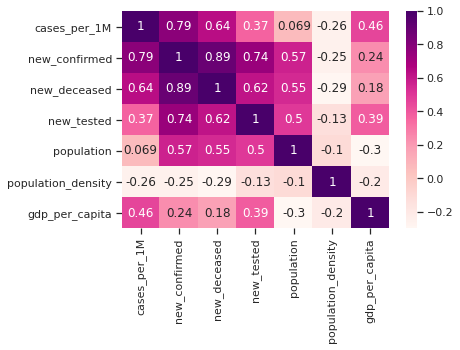

In [57]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrMatrix, annot = True, cmap = 'RdPu')
plt.show()

                        cases_per_1M  ...      gdp_per_capita
cases_per_1M             40726.80171  ...       1464270.41253
new_confirmed           615045.59544  ...      39576550.23353
new_deceased             10420.46635  ...        806838.51659
new_tested             7058219.45103  ...     855270076.99362
population         -1848826031.33734  ... -236798757206.61606
population_density    37426885.30793  ...   24789402267.63067
gdp_per_capita         1464270.41253  ...     689430612.06289

[7 rows x 7 columns]


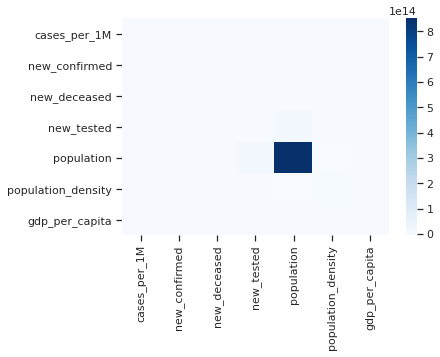

In [58]:
import seaborn as sn
import matplotlib.pyplot as plt
covMatrix = pd.DataFrame.cov(country_data)
print(covMatrix)
sn.heatmap(covMatrix, annot = False, cmap = 'Blues', robust = True)
plt.show()

## Split into Months
Using January data as our training set, and February data as our test set. CDC recognizes infection severity levels by the last 28 days which is roughly a month so we use these constraints to determine our levels for the months of January and February.

In [59]:
jan_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] < '2021-02-01')]

jan_data = jan_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'new_tested':	['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()



conditions = [  # if else basically
    (jan_data['cases_per_1M'] < 500), # level 1
    (jan_data['cases_per_1M'] >= 500) & (jan_data['cases_per_1M'] < 1000), # level 2
    (jan_data['cases_per_1M'] >=  1000) # level 3
    ]
values = [1, 2, 3]

## true labels for our training data
jan_data['levels'] = np.select(conditions, values)

jan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            203 non-null    object 
 1   (cases_per_1M, sum)         203 non-null    float64
 2   (new_confirmed, sum)        203 non-null    float64
 3   (population, mean)          203 non-null    float64
 4   (population_density, mean)  203 non-null    float64
 5   (new_deceased, sum)         203 non-null    float64
 6   (new_tested, sum)           203 non-null    float64
 7   (gdp_per_capita, mean)      203 non-null    int64  
 8   (levels, )                  203 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 14.4+ KB


In [60]:
jan_data = jan_data.set_index(['country_name'])

In [61]:
feb_data = country_data[(country_data['date'] >= '2021-02-01') & (country_data['date'] <= '2021-02-28')]

feb_data = feb_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_1M': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'new_tested':	['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()


conditions = [  # if else basically
    (feb_data['cases_per_1M'] < 500), # level 1
    (feb_data['cases_per_1M'] >= 500) & (feb_data['cases_per_1M'] < 1000), # level 2
    (feb_data['cases_per_1M'] >=  1000) # level 3
    ]
values = [1, 2, 3]

## true labels for our testing data 
feb_data['levels'] = np.select(conditions, values)

feb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            202 non-null    object 
 1   (cases_per_1M, sum)         202 non-null    float64
 2   (new_confirmed, sum)        202 non-null    float64
 3   (population, mean)          202 non-null    float64
 4   (population_density, mean)  202 non-null    float64
 5   (new_deceased, sum)         202 non-null    float64
 6   (new_tested, sum)           202 non-null    float64
 7   (gdp_per_capita, mean)      202 non-null    int64  
 8   (levels, )                  202 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 14.3+ KB


In [62]:
feb_data = feb_data.set_index(['country_name'])

## Construct our Response Variable: Each countries labels (overall for january and february)

We can see that the classes are severity imbalanced, with level 2 being the minority class

## Training set

In [63]:



train_X = jan_data.drop(['levels'], axis = 1)
train_X['population_density'].fillna((feb_data['population_density'].mean()), inplace=True)
train_X

,cases_per_1M,new_confirmed,population,population_density,new_deceased,new_tested,gdp_per_capita
,sum,sum,mean,mean,sum,sum,mean
country_name,,,,,,,
Afghanistan,65.11965,2535.00000,38928341.00000,59627.00000,194.00000,0.00000,502
Albania,7081.05394,20269.00000,2862427.00000,99.60000,207.00000,96685.00000,5352
Algeria,181.70605,7968.00000,43851043.00000,18411.00000,138.00000,0.00000,3948
American Samoa,0.00000,0.00000,55196.00000,275985.00000,0.00000,0.00000,11466
Andorra,24008.28318,1855.00000,77265.00000,164394.00000,17.00000,0.00000,40886
...,...,...,...,...,...,...,...
Vanuatu,0.00000,0.00000,307150.00000,25197.00000,0.00000,0.00000,3058
Vietnam,3.87308,377.00000,97338583.00000,313925.00000,0.00000,0.00000,2715


In [64]:
train_Y = jan_data['levels']
train_Y

country_name
Afghanistan       1
Albania           3
Algeria           1
American Samoa    1
Andorra           3
                 ..
Vanuatu           1
Vietnam           1
Yemen             1
Zambia            3
Zimbabwe          3
Name: levels, Length: 203, dtype: int64

## Testing Set

In [65]:
import statistics

test_X = feb_data.drop(['levels'],axis = 1).fillna(0)
test_X['population_density'].fillna((feb_data['population_density'].mean()), inplace=True)

In [66]:
test_Y = feb_data['levels']
test_Y

country_name
Afghanistan       1
Albania           3
Algeria           1
American Samoa    1
Andorra           3
                 ..
Vanuatu           1
Vietnam           1
Yemen             1
Zambia            3
Zimbabwe          1
Name: levels, Length: 202, dtype: int64

In [67]:
print('Training Set Shape:')
print('Features:', train_X.shape)
print('True Class Levels:', train_Y.shape)
print('Testing Set Shape:')
print('Features', test_X.shape)
print('True Class Levels:', test_Y.shape)

Training Set Shape:
Features: (203, 7)
True Class Levels: (203,)
Testing Set Shape:
Features (202, 7)
True Class Levels: (202,)


## Oversampling

Since there is class imbalance especially among level 2, we use the SMOTEEN package to oversample.

In [68]:
from collections import Counter
from imblearn.combine import SMOTEENN

length of oversampled data is  318
Number of countries level 1 in oversampled data 106
Number of countries level 2 in oversampled data 106
Number of countries level 3 in oversampled data 106


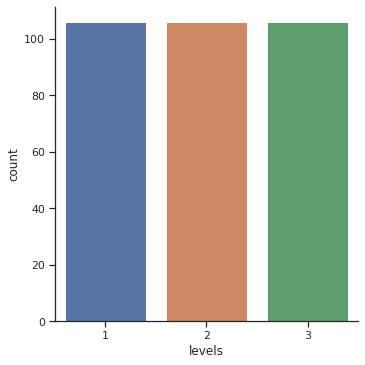

In [69]:
from imblearn.over_sampling import SMOTE
import seaborn as sns
os = SMOTE(random_state=0)
columns = train_X.columns
os_data_X,os_data_y=os.fit_sample(train_X, train_Y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['levels'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of countries level 1 in oversampled data",len(os_data_y[os_data_y['levels']==1]))
print("Number of countries level 2 in oversampled data",len(os_data_y[os_data_y['levels']==2]))
print("Number of countries level 3 in oversampled data",len(os_data_y[os_data_y['levels']==3]))
sns.set_theme(style="ticks")
sns.color_palette("husl", 3)

y_os = sns.catplot(x = "levels", kind = "count", data = os_data_y, order = [1, 2, 3])

## OVR Logistic Regression

Regular Logistic Regression is for binary responses which is why we opt for different variants of logistic regression for multi-classification.



In [70]:
from sklearn.linear_model import LogisticRegression
logmod_ovr = LogisticRegression(multi_class='ovr').fit(os_data_X, os_data_y.values.ravel())

In [71]:
print(logmod_ovr.score(test_X, test_Y)) # accuracy

0.9752475247524752


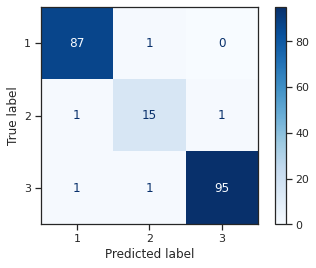

In [72]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


levels = ['1','2','3']
ovrdisp = plot_confusion_matrix(logmod_ovr, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

In [73]:
import sklearn.metrics as metrics
import plotly.figure_factory as ff
print(metrics.classification_report(test_Y, logmod_ovr.predict(test_X))) # classification report



              precision    recall  f1-score   support

           1       0.98      0.99      0.98        88
           2       0.88      0.88      0.88        17
           3       0.99      0.98      0.98        97

    accuracy                           0.98       202
   macro avg       0.95      0.95      0.95       202
weighted avg       0.98      0.98      0.98       202



## Multinomial Logistic Regression

In [74]:
logmod_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs').fit(os_data_X, os_data_y.values.ravel())

In [75]:
logmod_multi.score(test_X, test_Y)


0.7425742574257426

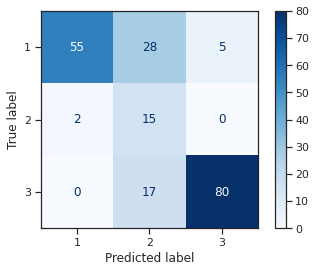

In [76]:
multidisp = plot_confusion_matrix(logmod_multi, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

In [77]:
print(metrics.classification_report(test_Y, logmod_multi.predict(test_X)))# classification report



              precision    recall  f1-score   support

           1       0.96      0.62      0.76        88
           2       0.25      0.88      0.39        17
           3       0.94      0.82      0.88        97

    accuracy                           0.74       202
   macro avg       0.72      0.78      0.68       202
weighted avg       0.89      0.74      0.79       202



## Ordinal Logistic Regression

In [78]:
!pip install mord
from mord import LogisticAT
ord = LogisticAT(alpha=0)
ord.fit(os_data_X,os_data_y.values.ravel())
ord_y = ord.predict(test_X)
print((metrics.accuracy_score(test_Y, np.round(ord_y)))) # accuracy


0.9207920792079208


In [79]:
metrics.confusion_matrix(test_Y,ord_y) # confusion matrix

array([[83,  5,  0],
       [ 3,  7,  7],
       [ 1,  0, 96]])

In [80]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y, ord.predict_proba(test_X), multi_class = 'ovr')

0.9454243621553954

In [81]:
print(metrics.classification_report(test_Y, ord.predict(test_X))) # classification report

              precision    recall  f1-score   support

           1       0.95      0.94      0.95        88
           2       0.58      0.41      0.48        17
           3       0.93      0.99      0.96        97

    accuracy                           0.92       202
   macro avg       0.82      0.78      0.80       202
weighted avg       0.91      0.92      0.91       202



## Multiclass Logistic Regression with Built in Cross Validation

In [82]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
clf = LogisticRegressionCV(cv = 10, random_state = 0, penalty = 'l2', solver = 'newton-cg', max_iter = 1000)
clf.fit(os_data_X, os_data_y.values.ravel())
clf_pred = clf.predict(test_X)
print(accuracy_score(test_Y, clf_pred))

0.9554455445544554


In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y, clf.predict_proba(test_X), multi_class = 'ovr')

0.9823460469912866

In [84]:
print(metrics.classification_report(test_Y, clf_pred)) # classification report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        88
           2       0.67      0.94      0.78        17
           3       0.99      0.92      0.95        97

    accuracy                           0.96       202
   macro avg       0.89      0.95      0.91       202
weighted avg       0.97      0.96      0.96       202



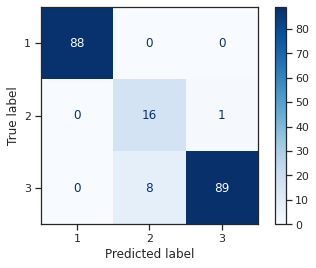

In [85]:
logcv_disp = plot_confusion_matrix(clf, test_X, test_Y,
                                 display_labels=levels,
                                 cmap=plt.cm.Blues)
plt.show()

## Model Selection/Conclusion

Out of all the logistic regression variants we have tried, the best accuracy, classification matrix, and classification report is OVR and the multiclass logistic regression with cross validation model. These two are pretty close in performance with OVR having slightly better performance in these measures.

In [86]:
print('OVR Logistic Regression Accuracy:', np.round(logmod_ovr.score(test_X, test_Y)*100))
print('Multinomial Logistic Regression Accuracy:', np.round(logmod_multi.score(test_X, test_Y)*100))
print('Ordinal Logistic Regression Accuracy:', np.round(metrics.accuracy_score(test_Y, np.round(ord_y))*100))
print('Multiclass Logistic Regression CV Accuracy:', np.round(accuracy_score(test_Y, clf_pred)*100))

OVR Logistic Regression Accuracy: 98.0
Multinomial Logistic Regression Accuracy: 74.0
Ordinal Logistic Regression Accuracy: 92.0
Multiclass Logistic Regression CV Accuracy: 96.0
